In [214]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [215]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
i2s = {p+1:l for p, l in enumerate(chars)}
i2s[0] = '.'

s2i = {}

for i, l in i2s.items():
    s2i[l] = i
    
vocab_size = len(s2i)

In [216]:
block_size = 8

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch] 
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(.8*len(words))
n2 = int(.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # train_words
Xdev, Ydev = build_dataset(words[n1:n2]) # dev_words
Xte, Yte = build_dataset(words[n2:]) # test_words



In [217]:
# SAME INSTANCES OF PYTORCH API BUT BUILT OUT WITH LESS FUNCTIONALITY TO UNDERSTAND

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):        # THIS CREATES A FLATTEN CLASS THAT TAKES THE AMOUNT OF CONTEXT TO FLTN
    self.n = n
    
  def __call__(self, x):        # WHEN SEQUENTIAL CALLS THIS, IT CREATES THREE DIMENSIONAL TENSOR 
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
   
  def __call__(self, x):         # IE THIS IS CALLED 'model' AND WHEN ITS CALLED LATER IT LOOPS THRU AND 
    for layer in self.layers:    # DOES EACH TRANSFORM
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

# C = torch.randn((vocab_size, n_embd),            generator=g)  REMOVED THIS WITH CLASS: EMBEDDING
        
              # THIS WAS THE PREVIOUS WAY TO DO THIS, Sequential class fixes this
# layers = [  # THIS IS CREATING A LIST WHERE EACH TRANSFORM WILL HAPPEN::: EMB => Flat => WEIGHTS => BATCHNORM => TanH
#   Embedding(vocab_size, n_embd), Flatten(),
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
model = Sequential([      # CREATING SEQUENTIAL CLASS THAT IS CALLED TO LOOP THROUGH LAYERS
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])




with torch.no_grad():
  # last layer: make less confident
    layers[-1].gamma *= 0.1
#   layers[-1].weight *= 0.1
  # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

         

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

params = sum(params.nelement() for params in parameters)
print(f"there are {params} parameters in total") # number of parameters in total


there are 45597 parameters in total


In [223]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
      
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # CREATES RAND INTS OF "BATCH SIZE" FROM 0 => Training size
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #   forward pass          SIMPLIFIED BY ADDING EMBED AND FLATTEN CLASSES
#     emb = C[Xb] # embed the characters into vectors
#     print(emb.shape)
#     x = emb.view(emb.shape[0], -1) # concatenate the vectors
#     x = Xb
#     for layer in layers:  # LOOP THE LAYERS AND PERFORM TRANSFORM
        

    logits = model(Xb) # CALLING THE SEQUENTIAL CLASS MADE EARLIER
    loss = F.cross_entropy(logits, Yb) # loss function
    
    

  # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        if i % 1000 == 0:
            print("training network ...")
#         print("Test Stage - Remove Break")
#         break # AFTER_DEBUG: would take out obviously to run full optimization

print("finished")

      0/  20000: 2.2954
training network ...
training network ...
training network ...
training network ...
training network ...
training network ...
training network ...
training network ...
training network ...
  10000/  20000: 2.2487
training network ...
training network ...
training network ...
training network ...
training network ...
training network ...
training network ...
training network ...
training network ...
training network ...
finished


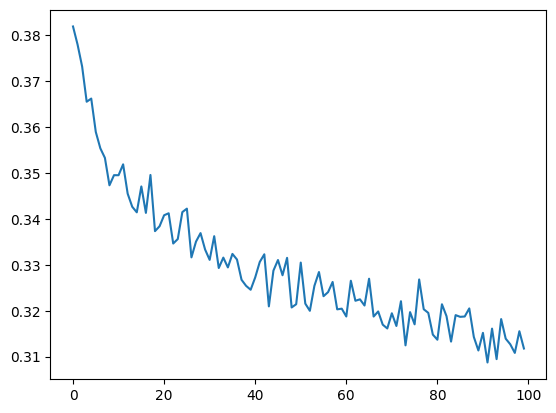

In [224]:

for layer in model.layers:
    layer.training = False

lossi_tensor = torch.tensor(lossi)
plt.plot(lossi_tensor.view(-1, 200).mean(1, keepdim=True))


In [232]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 15)
block_size = 8

for _ in range(3):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
#         emb = C[torch.tensor([context])] # (1,block_size,n_embd)
#         x = emb.view(emb.shape[0], -1) # concatenate the vectors
        
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
      # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
      # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(i2s[i] for i in out)) # decode and print the generated word

16
1
9
4
1
8
0
paidah.
16
15
8
1
5
12
25
14
0
pohaelyn.
20
18
1
24
19
0
traxs.


In [234]:
# VISUALISATION OF MODEL


ix = torch.randint(0, Xtr.shape[0], (4,)) # GETTING 4 examples of random integers ie => tensor([37505, 99034,  6899, 19835])
print("random index to create batch")
print("ix = torch.randint(0, Xtr.shape[0], (4,))")
print(ix)
print("----------------- \n")

print("Xtr is just a collection of tensors which are the indexs of each letter")
print(f"Entry 4 into Xtr {Xtr[4]}")
print("----------------- \n")


print("Index into batch")
print("Xb = Xtr[ix]")
Xb = Xtr[ix]                              # Batch by indexing into training data by 4 randoms places 
print(Xb)
print("----------------- \n")


print("Model is being called on the batch, giving probs of the next coming layer")
print("logits = model(Xb)")
logits = model(Xb)
print(logits[0])
print("----------------- \n")

print("Call softmax function to normalize the probs of next coming layer")
probs=F.softmax(logits, dim=1)
print(probs[0])
print("----------------- \n")

print("This created 4 new letters for each of the 4")
ix = torch.multinomial(probs, num_samples=1, generator=g)
print(ix)
print("----------------- \n")


print("This is the embedding layer, which takes the 4 samples X 8 context and adds n dimensions \n(originally 10 in example)")
print("(model.layers[0].out.shape)")
print(model.layers[0].out.shape)
print("----------------- \n")

print("This is the flatten layer, which takes the 8 context and 10 dimensions and but seperates them into \n4 groups of 2 by 10 dimensions")
print(model.layers[1].out.shape)
print("----------------- \n")

print("This is the linear layer, which takes the flattened matrix and multiplies by n amount of neurons")
print(model.layers[2].out.shape)
print("----------------- \n")

random index to create batch
ix = torch.randint(0, Xtr.shape[0], (4,))
tensor([50459, 91533, 56856, 64910])
----------------- 

Xtr is just a collection of tensors which are the indexs of each letter
Entry 4 into Xtr tensor([ 0,  0,  0,  0, 25, 21,  8,  5])
----------------- 

Index into batch
Xb = Xtr[ix]
tensor([[ 0,  0, 13,  9,  3,  8,  1,  5],
        [ 0,  0,  0,  0,  1,  2,  9,  7],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0, 18,  8,  9,  1, 14, 14, 15]])
----------------- 

Model is being called on the batch, giving probs of the next coming layer
logits = model(Xb)
tensor([ 3.6151, -1.0382,  0.8623, -1.3340,  1.3562,  0.2187, -1.0824, -0.1164,
        -1.0790, -1.6703, -1.5800, -2.2398,  5.1487,  1.5370,  0.1191, -1.5838,
        -0.4335, -4.1547,  1.2693,  2.8243,  0.0878, -3.4986, -0.1661, -3.6407,
        -3.3088,  0.1480,  0.0499], grad_fn=<SelectBackward0>)
----------------- 

Call softmax function to normalize the probs of next coming layer
tensor([1.4812e-01, 1